<a href="https://colab.research.google.com/github/deshanchathusanka/machine-learning-algorithms/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=06530cd1d1739fe599d530bd9301580d72cb53a59a1a7cf8aee646e728a3d5ba
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/tstLabel_fine.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/tstLabel_coarse.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/tstImage.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/trnLabel_fine.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/trnLabel_coarse.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/trnImage.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/fine_labels.csv" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/coarse_labels.csv" "/content/"

!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/x_train.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/x_test.npy" "/content/"

Mounted at /content/drive


**Import Statements**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
from sklearn.preprocessing import StandardScaler

############### Dimensionality Reduction ################
from sklearn.decomposition import PCA
from bisect import bisect_left
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


############## Support Vector Machine ###################
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

############## Convolutional Neural Network #########################
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

**Review Dataset and Labels**

Number of Fine Labels(Class) : (100,)
Number of Coarse Labels(Super Class) : (20,)

Shape of Original Images : (32, 32, 3, 50000)
Shape of Fine Labels : (50000,)
Shape of Coarse Labels : (50000,)



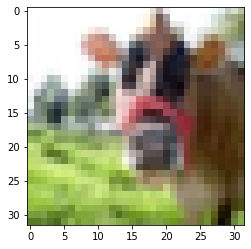

Fine Label : cattle
Coarse Label : large omnivores and herbivores


In [ ]:
images = np.load('./trnImage.npy')
images_test = np.load('./tstImage.npy')

label_fine = np.load('./trnLabel_fine.npy')
label_coarse = np.load('./trnLabel_coarse.npy')
label_fine_test = np.load('./tstLabel_fine.npy')
label_coarse_test = np.load('./tstLabel_coarse.npy')
label_fine_names = pd.read_csv("fine_labels.csv", header=None, delimiter=',').iloc[0]
label_coarse_names = pd.read_csv("coarse_labels.csv", header=None, delimiter=',').iloc[0]

############## shapes of dataset ###################
print(f'Number of Fine Labels(Class) : {label_fine_names.shape}')
print(f'Number of Coarse Labels(Super Class) : {label_coarse_names.shape}\n')
print(f'Shape of Original Images : {images.shape}') # (Height, Width, Channel, Samples)
print(f'Shape of Fine Labels : {label_fine.shape}')
print(f'Shape of Coarse Labels : {label_coarse.shape}\n')

############# understand dataset content ###############
img_index = 0
image = images[:,:,:,img_index]
plt.figure()
plt.imshow(image)
plt.show()
label_fine_name = label_fine_names[label_fine[img_index]]
label_course_name = label_coarse_names[label_coarse[img_index]]
print(f'Fine Label : {label_fine_name}')
print(f'Coarse Label : {label_course_name}')

**Manual Feature Extraction Using HOG (Histogram of Oriented Gradient)**

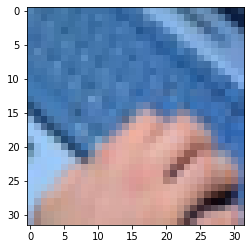

Number of Hog Feature : (576,)


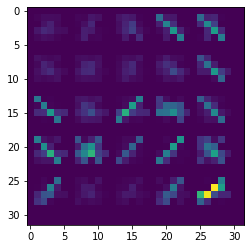

In [ ]:
NO_TRAIN_SAMPLE = 50000
NO_TEST_SAMPLE = 10000
NO_OF_FEATURE = 576
NO_OF_FINE_CATEGORIES = 100
NO_OF_COARSE_CATEGORIES = 100

########################### manually extract features of images and store in a file ###############################
image = images[:, :, :, 10]
plt.figure()
plt.imshow(image)
plt.show()
hog_feature, hog_image = skimage.feature.hog(image, pixels_per_cell=[6,6], cells_per_block=[2,2], visualize=True)
print(f'Number of Hog Feature : {hog_feature.shape}')
plt.figure()
plt.imshow(hog_image)
plt.show()

# x_train = np.empty(shape = (NO_TRAIN_SAMPLE, NO_OF_FEATURE))
# for index in range(0, NO_TRAIN_SAMPLE): # Training images
#   image = images[:, :, :, index]
#   hog_feature = skimage.feature.hog(image, pixels_per_cell=[6,6], cells_per_block=[2,2], visualize=False)
#   x_train[index] = hog_feature
# np.save(file = 'x_train.py', arr = x_train)

# x_test = np.empty(shape = (NO_TEST_SAMPLE, NO_OF_FEATURE))
# for index in range(0, NO_TEST_SAMPLE): # Testing images
#   image = images_test[:, :, :, index]
#   hog_feature = skimage.feature.hog(image, pixels_per_cell=[6,6], cells_per_block=[2,2], visualize=False)
#   x_test[index] = hog_feature
# np.save(file = 'x_test.py', arr = x_test)



In [ ]:
############### load feature extracted training and testing dataset ##############
x_train = np.load('./x_train.npy')
x_test = np.load('./x_test.npy')
y_train = label_fine
y_test = label_fine_test
y_train_coarse = label_coarse
y_test_coarse = label_coarse_test
print(f'Shape of X_Train : {x_train.shape}')
print(f'Shape of X_Test : {x_test.shape}')

############### Data standardization #################
scaler = StandardScaler()
# Calculate mean and variance of each feature for further pre-processing
scaler.fit(X = x_train) 
print(f'Shape of mean of dataset : {scaler.mean_.shape}') # (13,)
# Standardize data (Centering and Scaling)
x_train_standard = scaler.transform(X = x_train)
x_test_standard = scaler.transform(X = x_test)



Shape of X_Train : (50000, 576)
Shape of X_Test : (10000, 576)
Shape of mean of dataset : (576,)


**Dimensionality Reduction**

 
 The main purpose of applying dimensionality reduction is to extract small number of new features(priciple components) that can explain more than 90% of total varience of original data.

Number of priciple components required to achieve 90% of total varience : 157


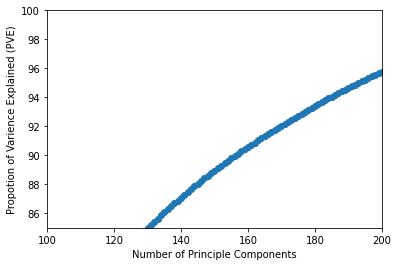

In [ ]:
pca = PCA().fit(X = x_train_standard, y = y_train)
singular_values = pca.explained_variance_
right_singular_vectors = pca.components_
singular_values_normalized = singular_values/sum(singular_values)

cum_sum_var = np.cumsum(singular_values_normalized)
num_components_90 = bisect_left(cum_sum_var, 0.9) + 1
print(f'Number of priciple components required to achieve 90% of total varience : {num_components_90}')

plt.figure()
plt.scatter(x = range(1, len(singular_values)+1), y = cum_sum_var*100)
plt.xlabel(xlabel = "Number of Principle Components")
plt.ylabel(ylabel = "Propotion of Varience Explained (PVE)")
plt.ylim([85,100])
plt.xlim([100,200])
plt.show()


In [ ]:
x_train_standard_reduced = pca.transform(X = x_train_standard)[:, 0: 157]
x_test_standard_reduced = pca.transform(X = x_test_standard)[:, 0: 157]

print(x_train_standard_reduced.shape)

(50000, 157)


In [ ]:
################## extract LDA components ######################
"""
max(components) = min(features, classes-1)
"""
lda = LinearDiscriminantAnalysis(n_components = 99) 
lda.fit(X = x_train_standard, y = y_train)

#################### calculate LDA components ##################
x_train_standard_lda = lda.transform(X = x_train_standard)[:, 0: 99]
x_test_standard_lda = lda.transform(X = x_test_standard)[:, 0: 99]


**Support Vector Machine**


* Features = HoG(Image) = 576

* Input = (50000, 576) = (Samples, Features)

* Output = (50000, 1)

In [ ]:
############################ Kernal selection : K-Fold cross validation ################################
def select_kernal(k, candidate_kernels, x_train, y_train, base_model) :

  model_fold_accuracy_map = []
  skf = StratifiedKFold(n_splits = k)
  for (train_index, val_index) in skf.split(X = x_train, y = y_train) :
    x_train_i, x_val_i = x_train[train_index], x_train[val_index]
    y_train_i, y_val_i = y_train[train_index], y_train[val_index]

    kernal_accuracy_i = []
    for kernel in candidate_kernels : 
      clf_param = dict(kernel = kernel)
      base_model.set_params(**clf_param)

      base_model.fit(X = x_train_i, y = y_train_i) 
      accuracy = base_model.score(X = x_val_i, y = y_val_i)
      kernal_accuracy_i.append(accuracy)
    model_fold_accuracy_map.append(kernal_accuracy_i)

  model_fold_accuracy_map = np.array(model_fold_accuracy_map)
  model_accuracy_list = np.sum(model_fold_accuracy_map, axis = 0)

  best_model_index = np.max(model_accuracy_list, axis = 0)
  best_kernel = candidate_kernels[best_model_index]

  return best_kernel

In [ ]:
###################Train Support Vector Machine Classifier #########################
svc = SVC(C = 1, kernel = 'rbf') 

candidate_kernels = ['linear', 'poly', 'rbf']
k = 3
# selected_kernel = select_kernal(k, candidate_kernels, x_train_standard_reduced[0:10000,:], y_train_coarse[0:10000], svc)
# print(select_kernal)
# clf_param = dict(kernel = selected_kernel)
# svc.set_params(**clf_param)

svc.fit(X = x_train_standard_lda, y = y_train_coarse) 
accuracy = svc.score(X = x_test_standard_lda, y = y_test_coarse)
print(accuracy)


0.3464


**Artificial Neural Network**

Epoch 1/8
400/400 [==============================] - 8s 17ms/step - loss: 2.4950 - sparse_categorical_accuracy: 0.2402 - val_loss: 2.2734 - val_sparse_categorical_accuracy: 0.3045
Epoch 2/8
400/400 [==============================] - 5s 12ms/step - loss: 2.1459 - sparse_categorical_accuracy: 0.3399 - val_loss: 2.1633 - val_sparse_categorical_accuracy: 0.3395
Epoch 3/8
400/400 [==============================] - 5s 12ms/step - loss: 1.9922 - sparse_categorical_accuracy: 0.3861 - val_loss: 2.1202 - val_sparse_categorical_accuracy: 0.3509
Epoch 4/8
400/400 [==============================] - 4s 11ms/step - loss: 1.8696 - sparse_categorical_accuracy: 0.4230 - val_loss: 2.1090 - val_sparse_categorical_accuracy: 0.3582
Epoch 5/8
400/400 [==============================] - 5s 12ms/step - loss: 1.7648 - sparse_categorical_accuracy: 0.4527 - val_loss: 2.1113 - val_sparse_categorical_accuracy: 0.3604
Epoch 6/8
400/400 [==============================] - 5s 11ms/step - loss: 1.6733 - sparse_categorica

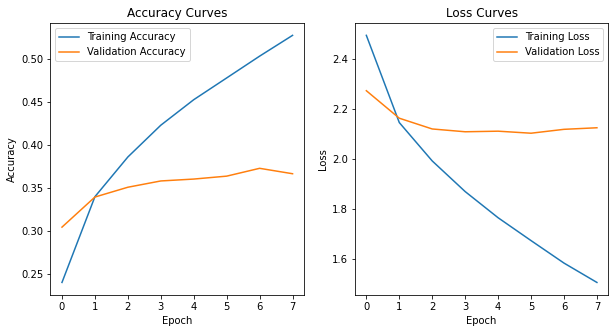

313/313 [==============================] - 2s 4ms/step - loss: 2.1136 - sparse_categorical_accuracy: 0.3662
Test set loss: 2.11, test set accuracy: 36.62%


In [ ]:
""" Define ANN Model """

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(400, activation=tf.nn.relu)) # 1st hidden layer : 784 neurons
model.add(Dropout(0.10))
model.add(tf.keras.layers.Dense(400, activation=tf.nn.relu)) # 1st hidden layer : 784 neurons
model.add(Dropout(0.10))
model.add(tf.keras.layers.Dense(20, activation=tf.nn.softmax)) # output layer : 3 neurons

""" Compile Model """
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), # Strochastic Gradient Descent
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy

""" Train The Model """
# history = model.fit(x_train_standard, y_train_coarse, epochs=100, validation_split=0.2, verbose=1)
history = model.fit(x = x_train_standard,
                    y = y_train_coarse, 
                    batch_size = 100,
                    epochs=8, 
                    validation_split=0.2, 
                    verbose=1)

"""  Plot Accuracy And Loss Curves """
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

# # Predict labels from trained model
# y_hat = model.predict(x_test_mnist_normalized)

# """ Evaluate With Test Datatset """
#results = model.evaluate(x_test_standard, y_test_coarse)
results = model.evaluate(x_test_standard, y_test_coarse)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

# """ Analyse Training Cureves """
# print(y_test_mnist)
# print(np.argmax(y_hat, axis=1))

In [ ]:
from sklearn.model_selection import cross_val_score
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = SGD(lr = learning_rate)
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(neurons, activation=activation)) # 1st hidden layer : 784 neurons
        model.add(Dropout(0.10))
        model.add(tf.keras.layers.Dense(neurons, activation=activation)) # 1st hidden layer : 784 neurons
        model.add(Dropout(0.10))
        model.add(tf.keras.layers.Dense(neurons, activation=tf.nn.softmax)) # output layer : 3 neurons

        """ Compile Model """
        model.compile(optimizer=opt, # Strochastic Gradient Descent
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
                      metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy


        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, x_train_standard_lda, y_train_coarse, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score



score_acc = make_scorer(accuracy_score)
# Set paramaters
params_nn ={
    'neurons': (10, 400),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)


params_nn_ = nn_bo.max['params']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------
|  1        |  nan      |  5.51     |  335.3    |  54.88    |  0.7716   |  125.2    |  1.044    |
|  2        |  nan      |  0.2023   |  536.2    |  39.09    |  0.3443   |  396.4    |  1.664    |
|  3        |  nan      |  0.7307   |  735.7    |  69.7     |  0.2815   |  191.8    |  0.8286   |
|  4        |  nan      |  0.6656   |  920.6    |  83.52    |  0.8422   |  327.9    |  6.937    |
|  5        |  nan      |  5.195    |  851.0    |  53.71    |  0.03717  |  187.1    |  0.7373   |
|  6        |  nan      |  7.355    |  758.2    |  65.22    |  0.2815   |  399.4    |  0.9663   |
|  7        |  nan      |  5.539    |  588.0    |  52.4     |  0.7306   |  135.9    |  2.804    |
|  8        |  nan      |  2.871    |  957.8    |  93.5     |  0.8157   |  23.29    |  6.604    |
|  9        |  nan  

ValueError: ignored

**Convolution Neural Network (CNN)**

Input = (50000, 32, 32, 3) = (Samples, Height, Width, Channel)


In [ ]:
################### Dimension of X = (S, H, W, C) = (Samples, Height, Width, Channel) ########################
x_cnn_train = np.transpose(a = images, axes = (3,0,1,2))
x_cnn_test = np.transpose(a = images_test, axes = (3,0,1,2))
print(x_cnn_train.shape)
print(x_cnn_test.shape)

####################### Normalize Pixel Values ############################
max_pixel_value = np.max(x_cnn_train)
x_cnn_train_norm = x_cnn_train/max_pixel_value
x_cnn_test_norm = x_cnn_test/max_pixel_value

################### Define Image Sizes ##############################
Image_Width = 32 # pixel width of image.
Image_Height = 32 # pixel height of image.
Image_Size = (Image_Width, Image_Height) # resolution of image.
Image_Channels=3 # number of colour channels in images.

######## Feature Extraction Layers = Convolutional-Subsampling Pairs (Increase number of feature maps for each subsequent pairs) #########
# building a linear stack of layers with the sequential model
model = Sequential()

## 32
model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

## 16
model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.15))

## 8
model.add(Conv2D(1024, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(1024, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(1024, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.20))

## 4
# model.add(Conv2D(2048, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
# model.add(Conv2D(2048, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
# model.add(Conv2D(2048, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

## 2
#################### classification layers ############################
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(20, activation='softmax'))

################### Build the model ######################
amd_opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = amd_opt, # Strochastic Gradient Descent
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy

################# Print The Summary #################
model.summary()


################# Train The Model ######################
history = model.fit(x_cnn_train_norm, y_train_coarse, epochs=50, validation_split=0.2, verbose=1)

################ Plot Accuracy And Loss Curves ################
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

################# Predict labels from trained model ########################
""" output = (10000, 100) """
# y_hat = model.predict(x_cnn_test_norm) 

################### Evaluate With Test Datatset ###########################
# results = model.evaluate(x_cnn_test_norm, y_test)
# print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

################### Analyse Training Cureves ########################
# print(y_test)
# print(np.argmax(y_hat, axis=1))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       1664      
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       65664     
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       65664     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 512)       262656    
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 512)       1049088   
                

KeyboardInterrupt: ignored

**Transfer Learning With VGG-16**

https://d2l.ai/chapter_convolutional-modern/vgg.html
https://machinelearningmastery.com/

how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

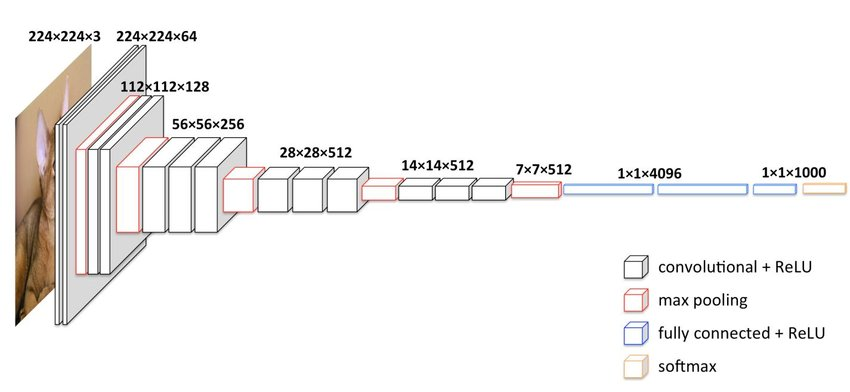

(50000, 32, 32, 3)
(10000, 32, 32, 3)
58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 500)               256500    
                                                                 
 dense_19 (Dense)            (None, 100)               50100     
                                                                 
Total params: 15,021,288
Trainable params: 306,600
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
1250/1250 [==============================] - 23s 12ms

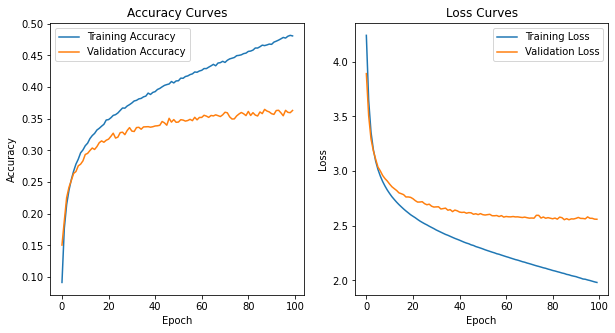

In [ ]:
############################## Transfer Learning ######################################
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np

################### pre-process images ######################################
x_cnn_train = np.transpose(a = images, axes = (3,0,1,2))
x_cnn_test = np.transpose(a = images_test, axes = (3,0,1,2))
print(x_cnn_train.shape)
print(x_cnn_test.shape)

####################### Normalize Pixel Values ############################
max_pixel_value = np.max(x_cnn_train)
x_cnn_train_norm = x_cnn_train/max_pixel_value
x_cnn_test_norm = x_cnn_test/max_pixel_value


####################### define transfer learning base model #################
INPUT_IMAGE_SIZE = [32, 32, 3]

vgg_16 = VGG16(
    include_top = False, #### remove top(Dense) layers 
    weights = "imagenet",
    input_shape = INPUT_IMAGE_SIZE
)
vgg_16.trainable = False #### avoid retrain the feature extraction layers

########### feature extraction layers ###############
model = Sequential()
model.add(vgg_16)

########### classification layers ##################
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='softmax'))

################### Build the model ######################
model.compile(optimizer=tf.keras.optimizers.SGD(), # Strochastic Gradient Descent
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy

################# Print The Summary #################
model.summary()

################# Train The Model ######################
history = model.fit(x_cnn_train_norm, y_train, epochs=100, validation_split=0.2, verbose=1)

################ Plot Accuracy And Loss Curves ################
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()



**References**

https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/